# 자전거 쉐어링 수요 예측

# 1. 데이터 불러오기

In [81]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# 노트북 안에 그래프를 그리기 위해
%matplotlib inline

# 그래프에서 격자로 숫자 범위가 눈에 잘  띄도록 ggplot 스타일 사용
plt.style.use('ggplot')

# 그래프에서 마이너스 폰트가 깨지는 문제 해결
mpl.rcParams['axes.unicode_minus'] = False

In [59]:
train = pd.read_csv('./data/bike-sharing-demand/train.csv', parse_dates=['datetime'])
train.shape                                       # parse_dates를 이용해 datetime형식으로 불러오기

(10886, 12)

In [60]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB


In [61]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


### 데이터 설명

- datetime - hourly date + timestamp  
- season -  1 = spring, 2 = summer, 3 = fall, 4 = winter 
- holiday - whether the day is considered a holiday
- workingday - whether the day is neither a weekend nor holiday
- weather
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
- temp - temperature in Celsius
- atemp - "feels like" temperature in Celsius
- humidity - relative humidity
- windspeed - wind speed
- casual - number of non-registered user rentals initiated
- registered - number of registered user rentals initiated
- count - number of total rentals

In [62]:
train.temp.describe()

count    10886.00000
mean        20.23086
std          7.79159
min          0.82000
25%         13.94000
50%         20.50000
75%         26.24000
max         41.00000
Name: temp, dtype: float64

In [63]:
# null값 있는지 확인
train.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

In [64]:
# datetime 컬럼 쪼개서 추가로 6개 컬럼 새로 만들기
train['year'] = train['datetime'].dt.year
train['month'] = train['datetime'].dt.month
train['day'] = train['datetime'].dt.day
train['hour'] = train['datetime'].dt.hour
train['minute'] = train['datetime'].dt.minute
train['second'] = train['datetime'].dt.second
train.shape

(10886, 18)

In [65]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,minute,second
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0,0,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1,0,0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2,0,0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3,0,0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4,0,0


# 2. EDA

In [66]:
# seaborn, matplotlib 의 이미지에서 한글 표현하기
# 외우지말고 그냥 복붙해서 써도 됨

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
import platform
import seaborn as sns

# 이미지에 한글 표시 설정
if platform.system() == 'Windows': # 윈도우인 경우 맑은고딕
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
else :  # Mac인 경우 애플고딕
    rc('font', family='AppleGothic')

# 그래프에서 마이너스 기호가 표시되도록 하는 설정
matplotlib.rcParams['axes.unicode_minus'] = False

## 2.1. barplot

[Text(0.5, 0, 'hour'), Text(0.5, 1.0, '시간별 대여량')]

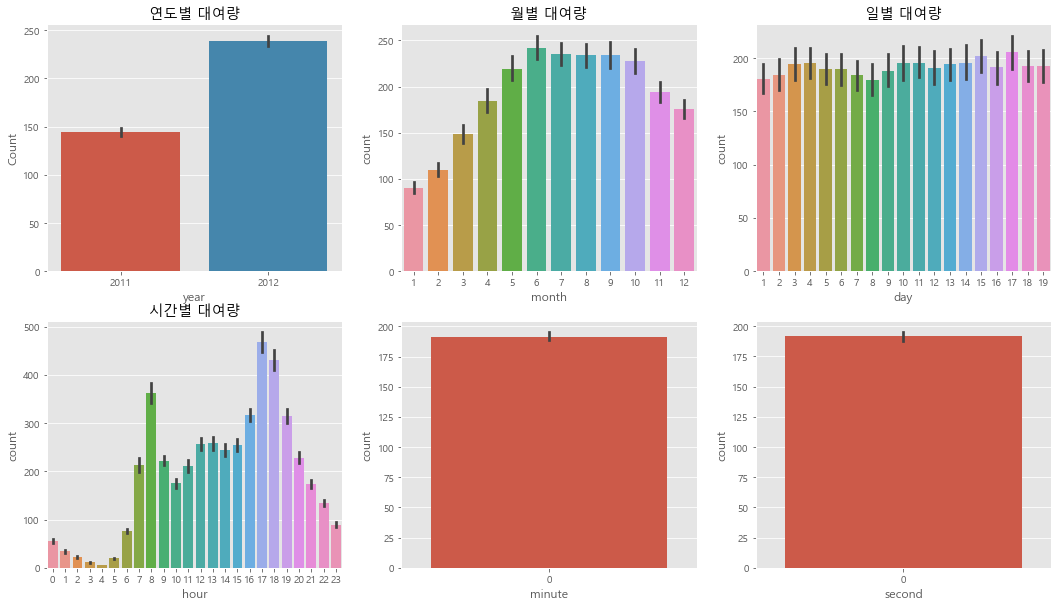

In [67]:
# 각 변수에 알리아스를 지정해서 그래프 그리기
figure, ((ax1,ax2,ax3), (ax4, ax5,ax6)) = plt.subplots(nrows=2, ncols=3)
figure.set_size_inches(18,10)

sns.barplot(data=train, x='year', y='count', ax=ax1)
sns.barplot(data=train, x='month', y='count', ax=ax2)
sns.barplot(data=train, x='day', y='count', ax=ax3)
sns.barplot(data=train, x='hour', y='count', ax=ax4)
sns.barplot(data=train, x='minute', y='count', ax=ax5)
sns.barplot(data=train, x='second', y='count', ax=ax6)

# 제목 추가
ax1.set(ylabel='Count', title='연도별 대여량')
ax2.set(xlabel='month', title='월별 대여량')
ax3.set(xlabel='day', title='일별 대여량')
ax4.set(xlabel='hour', title='시간별 대여량')

- 연도별 대여량은 2011년보다 2012년이 더 많다.
- 월별 대여량은 5~10월이 많다.
- 일별 대여량은 1~19일만 나타나있고 나머지 데이터는 test.csv에 있기 때문에 피처로 사용할 수 없다.
- 시간별 대여량은 출퇴근 시간이 많다. 그러나 평일과 주말을 구분해서 볼 필요가 있다.
- 분과 초는 다 0으로 나타냈기에 의미가 없다.

## 2.2. boxplot

[Text(0, 0.5, 'Count'),
 Text(0.5, 0, 'Working Day'),
 Text(0.5, 1.0, '근무일 여부에 따른 대여량')]

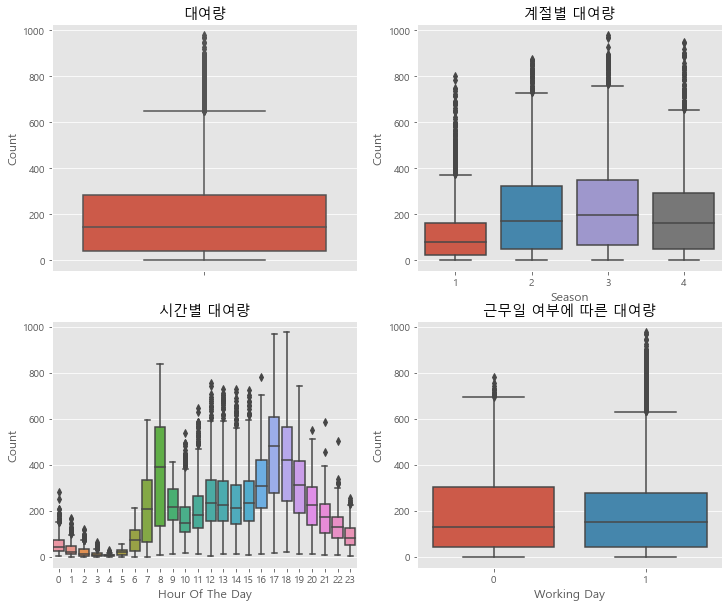

In [68]:
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(12, 10)
sns.boxplot(data=train, y='count', orient='v', ax=axes[0][0])
sns.boxplot(data=train, y='count', orient='v', x='season', ax=axes[0][1])
sns.boxplot(data=train, y='count', orient='v', x='hour', ax=axes[1][0])
sns.boxplot(data=train, y='count', orient='v', x='workingday', ax=axes[1][1])

# 제목 추가
axes[0][0].set(ylabel='Count', title='대여량')
axes[0][1].set(ylabel='Count', xlabel='Season', title='계절별 대여량')
axes[1][0].set(ylabel='Count', xlabel='Hour Of The Day', title='시간별 대여량')
axes[1][1].set(ylabel='Count', xlabel='Working Day', title='근무일 여부에 따른 대여량')

- 계절별 대여량은 여름과 가을에 많고 봄에는 적다.
- 시간대별 대여량은 barplot에서 본 것과 유사하다.
- 근무 여부에 따른 대여량은 휴일(0)과 평일(1)이 큰 차이는 없지만 휴일이 다소 많다.

## 2.3. pointplot

In [71]:
# dayofweek(요일)는 위에서 train에 안 담아줘서 지금 담아준다.
train['dayofweek'] = train['datetime'].dt.dayofweek
train.shape

(10886, 19)

In [72]:
train['dayofweek'].value_counts()

5    1584
6    1579
3    1553
2    1551
0    1551
1    1539
4    1529
Name: dayofweek, dtype: int64

[Text(0.5, 0, 'hour'), Text(0.5, 1.0, '계절별 대여량')]

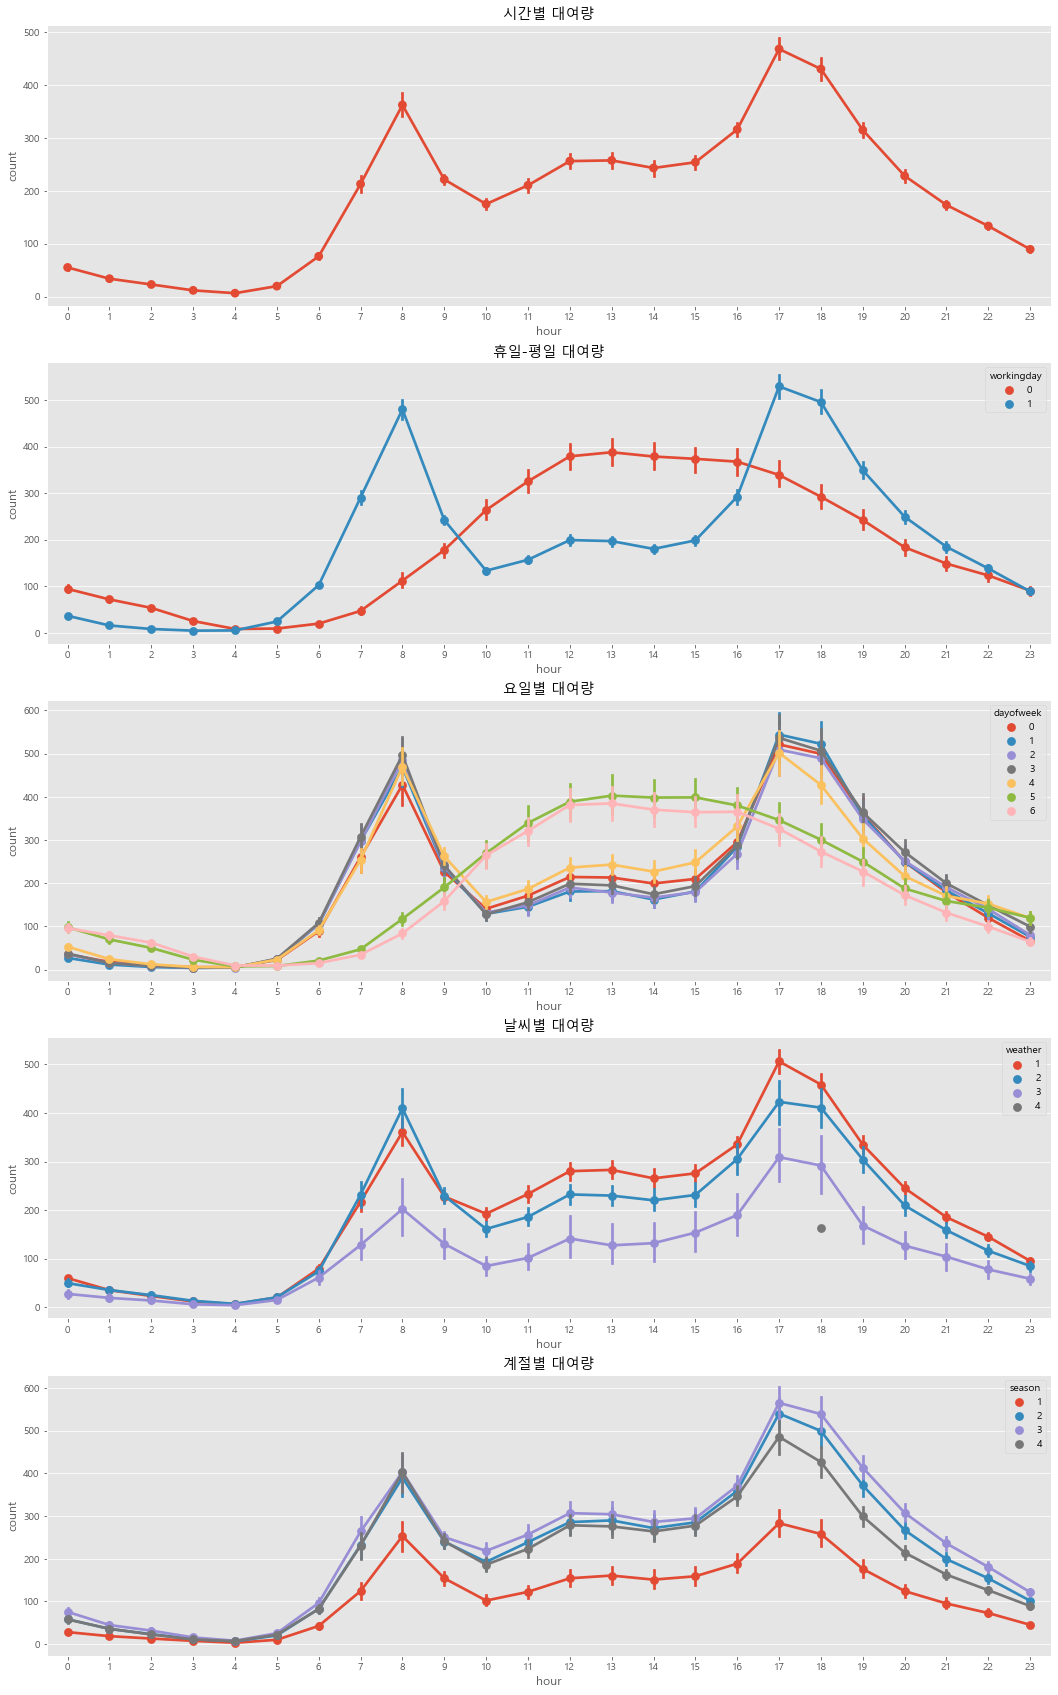

In [76]:
fig, (ax1,ax2,ax3,ax4,ax5)= plt.subplots(nrows=5)
fig.set_size_inches(18,30)

sns.pointplot(data=train, x='hour', y='count', ax=ax1)
sns.pointplot(data=train, x='hour', y='count', hue='workingday', ax=ax2)
sns.pointplot(data=train, x='hour', y='count', hue='dayofweek', ax=ax3)
sns.pointplot(data=train, x='hour', y='count', hue='weather', ax=ax4)
sns.pointplot(data=train, x='hour', y='count', hue='season', ax=ax5)

ax1.set(xlabel='hour', title='시간별 대여량')
ax2.set(xlabel='hour', title='휴일-평일 대여량')
ax3.set(xlabel='hour', title='요일별 대여량')
ax4.set(xlabel='hour', title='날씨별 대여량')
ax5.set(xlabel='hour', title='계절별 대여량')

- 평일(1)엔 출퇴근 시간에 대여량이 높지만, 휴일(0)엔 11~16시에 높다.
- 요일별 대여량도 위와 결과가 유사하다.
- 날씨별 대여량은 날씨가 좋을 때(1) 대여량이 높다.
- 계절별 대여량은 봄(1)이 가장 적고, 가을(3)이 가장 많다.

## 2.4. heatmap으로 상관계수 확인

In [82]:
# 상관계수 확인(히트맵 활용)
corrMatt = train[['temp', 'atemp', 'casual', 'registered', 'humidity', 'windspeed', 'count']]
corrMatt = corrMatt.corr()
print(corrMatt)

mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False

                temp     atemp    casual  registered  humidity  windspeed  \
temp        1.000000  0.984948  0.467097    0.318571 -0.064949  -0.017852   
atemp       0.984948  1.000000  0.462067    0.314635 -0.043536  -0.057473   
casual      0.467097  0.462067  1.000000    0.497250 -0.348187   0.092276   
registered  0.318571  0.314635  0.497250    1.000000 -0.265458   0.091052   
humidity   -0.064949 -0.043536 -0.348187   -0.265458  1.000000  -0.318607   
windspeed  -0.017852 -0.057473  0.092276    0.091052 -0.318607   1.000000   
count       0.394454  0.389784  0.690414    0.970948 -0.317371   0.101369   

               count  
temp        0.394454  
atemp       0.389784  
casual      0.690414  
registered  0.970948  
humidity   -0.317371  
windspeed   0.101369  
count       1.000000  


<AxesSubplot:>

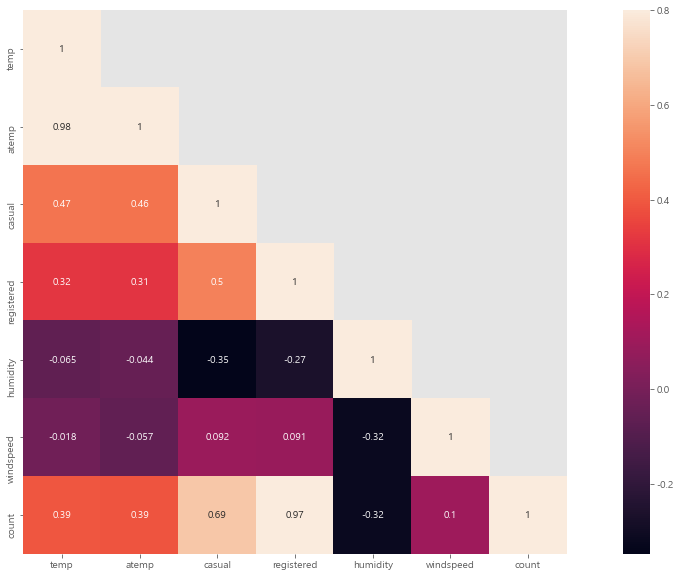

In [84]:
fig, ax = plt.subplots()
fig.set_size_inches(20,10)
sns.heatmap(corrMatt, mask=mask, vmax=.8, square=True, annot=True)

- temp, humidity, windspeed는 전체적으로 상관계수가 낮다.
- count(대여량)과 상관계수가 높은건 reistered(등록된 사용자)다.
- 그런데 reistered와 casual(비등록 사용자)은 train 데이터에만 있으므로 피처로 부적합하다.
- atemp(체감온도)와 temp(온도)는 서로 상관계수가 높아서 피처로 부적합하다.

## 2.5. regplot

<AxesSubplot:xlabel='humidity', ylabel='count'>

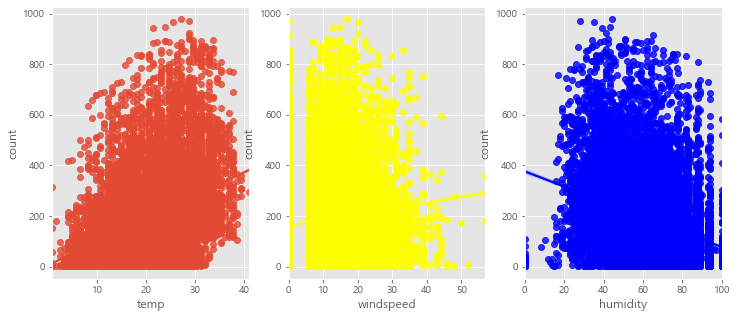

In [86]:
fig, (ax1,ax2,ax3) = plt.subplots(ncols=3)
fig.set_size_inches(12,5)
sns.regplot(x='temp', y='count', data=train, ax=ax1)
sns.regplot(x='windspeed', y='count', data=train, ax=ax2, color='yellow')
sns.regplot(x='humidity', y='count', data=train, ax=ax3, color='blue')

- windspeed의 경우 값이 0인 경우가 많은데, 이는 관측되지 않은 데이터로 추측된다.
- 따라서 피처 엔지니어링으로 조정할 필요가 있다.

## 2.6 연도-월별로 보기

In [87]:
def concatenate_year_month(datetime):
    return '{0}-{1}'.format(datetime.year, datetime.month)

train['year_month'] = train['datetime'].apply(concatenate_year_month)

print(train.shape)
train[['datetime', 'year_month']].head()

(10886, 20)


,datetime,year_month
0,2011-01-01 00:00:00,2011-1
1,2011-01-01 01:00:00,2011-1
2,2011-01-01 02:00:00,2011-1
3,2011-01-01 03:00:00,2011-1
4,2011-01-01 04:00:00,2011-1


<AxesSubplot:xlabel='year_month', ylabel='count'>

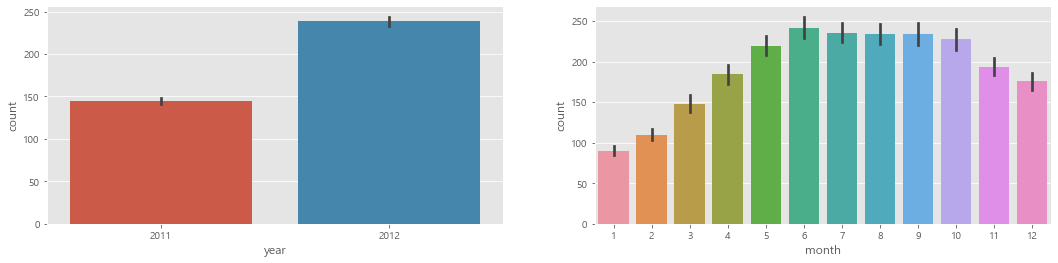

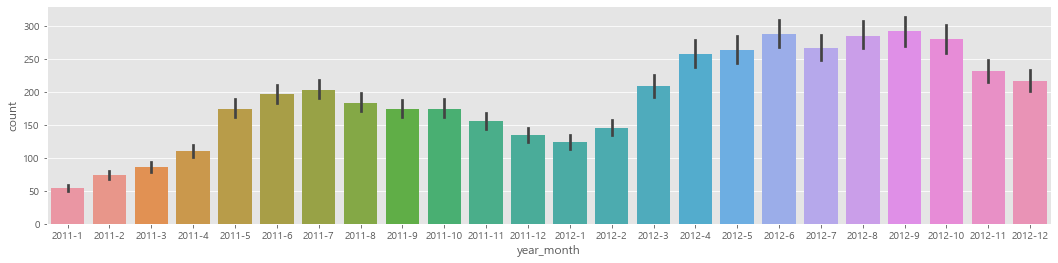

In [89]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(18,4)

sns.barplot(data=train, x='year', y='count', ax=ax1)
sns.barplot(data=train, x='month', y='count', ax=ax2)


fig, ax3 = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(18,4)

sns.barplot(data=train, x='year_month', y='count', ax=ax3)

마찬가지로 대여량은 2012년에 더 증가했으며 5~8월이 더 높다.

# 3. 이상치 제거

In [90]:
trainWithoutOutliers = train[np.abs(train['count'] - train['count'].mean()) <= (3*train['count'])]

print(train.shape)
print(trainWithoutOutliers.shape)

# 약 2800개의 데이터 제거

(10886, 20)
(8001, 20)


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


((array([-3.75512118, -3.52683847, -3.40136165, ...,  3.40136165,
          3.52683847,  3.75512118]),
  array([3.8918203 , 3.8918203 , 3.8918203 , ..., 6.87626461, 6.87832647,
         6.88550967])),
 (0.6811413933668109, 5.319241302387579, 0.992647986011948))

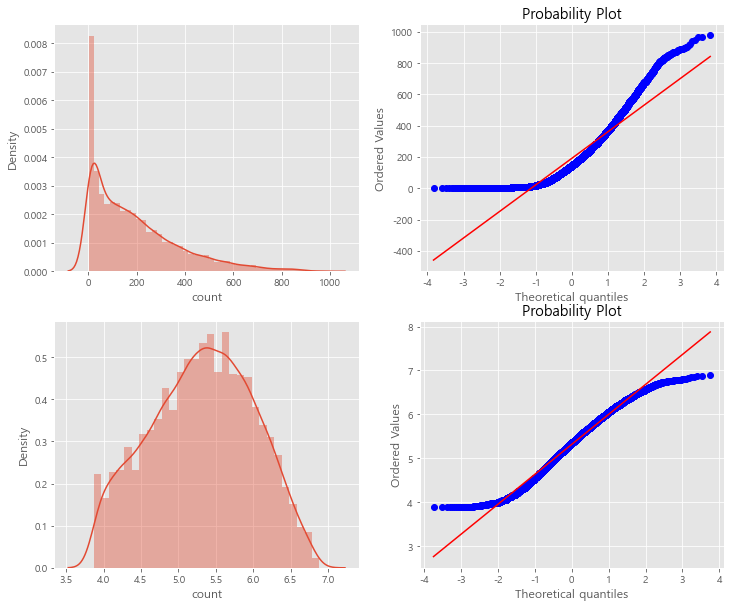

In [97]:
figure, axes = plt.subplots(ncols=2, nrows=2)
figure.set_size_inches(12, 10)

sns.distplot(train['count'], ax=axes[0][0])
stats.probplot(train['count'], dist='norm', fit=True, plot=axes[0][1])
sns.distplot(np.log(trainWithoutOutliers['count']), ax=axes[1][0])
stats.probplot(np.log1p(trainWithoutOutliers['count']), dist='norm', fit=True, plot=axes[1][1])

이상치를 제거하니 그래프가 정규분포에 가까워졌다.